# ML Project: Regression 

## News Popularity in Multiple Social Media Platforms

Authors:
`Andrea Murphy` and `Josh Quigley`

In [1]:
%matplotlib inline
import random

import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from time import time
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
import pylab as plot
params = { 
    "axes.labelsize": "large",
    "xtick.labelsize" : "x-large",
    "legend.fontsize": 20,
    "figure.dpi": 150,
    "figure.figsize" : [25, 7]
}
plot.rcParams.update(params)

In [3]:
# Load the dataset

data = pd.read_csv('News_Final.csv')
data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,4/2/02 0:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,9/20/08 0:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,1/28/12 0:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,3/1/15 0:06,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,3/1/15 0:11,0.000000,0.141084,-1,-1,-1


In [4]:
# The dataset has 91,229 records

data.tail()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
91225,60337.0,San Diego economy slips in May,San Diego County's economy slowed slightly in ...,The San Diego Union-Tribune,economy,6/30/16 23:47,0.000000,0.177667,-1,3,1
91226,103879.0,Durbin: Obama pal's ties to for-profit univers...,But now that one of President Barack Obama's c...,Chicago Tribune,obama,6/30/16 23:49,0.000000,0.110773,15,1,4
91227,60407.0,German economy minister: EU stability pact nee...,German Economy Minister Sigmar Gabriel has cal...,Reuters via Yahoo! Finance,economy,6/30/16 23:59,0.072169,-0.145833,-1,0,0
91228,60593.0,The Gig Economy's Growing Influence on the Ame...,There's been much debate about the rise of the...,Business News Daily,economy,7/1/16 0:00,-0.125000,0.027518,-1,0,29
91229,60597.0,This Is How Hillary Clinton Should Respond to ...,There's only one right move for the U.S. econo...,Fortune,economy,7/1/16 0:00,0.104167,-0.125574,-1,3,3


In [5]:
type(data.index)

pandas.core.indexes.range.RangeIndex

In [6]:
data.shape

(91230, 11)

In [7]:
data.keys()

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus',
       'LinkedIn'],
      dtype='object')

In [8]:
# Check to see if there are nulls

data.isnull().sum()

IDLink                 0
Title                  0
Headline              14
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

## Dropping null values in string subsets 

In [9]:
data = data.dropna(subset=['Headline', 'Source'], how='any')

In [10]:
# No more nulls
data.isnull().sum()

IDLink               0
Title                0
Headline             0
Source               0
Topic                0
PublishDate          0
SentimentTitle       0
SentimentHeadline    0
Facebook             0
GooglePlus           0
LinkedIn             0
dtype: int64

## Analyze the Data

In [11]:
#Lets look at coorelation. We found that Facebook popularity and GooglePlus popularity are the two most common features.

corr_matrix = data.corr()
corr_matrix["Facebook"].sort_values(ascending=False)

Facebook             1.000000
GooglePlus           0.509091
IDLink               0.109221
LinkedIn             0.066392
SentimentHeadline    0.000595
SentimentTitle      -0.003427
Name: Facebook, dtype: float64

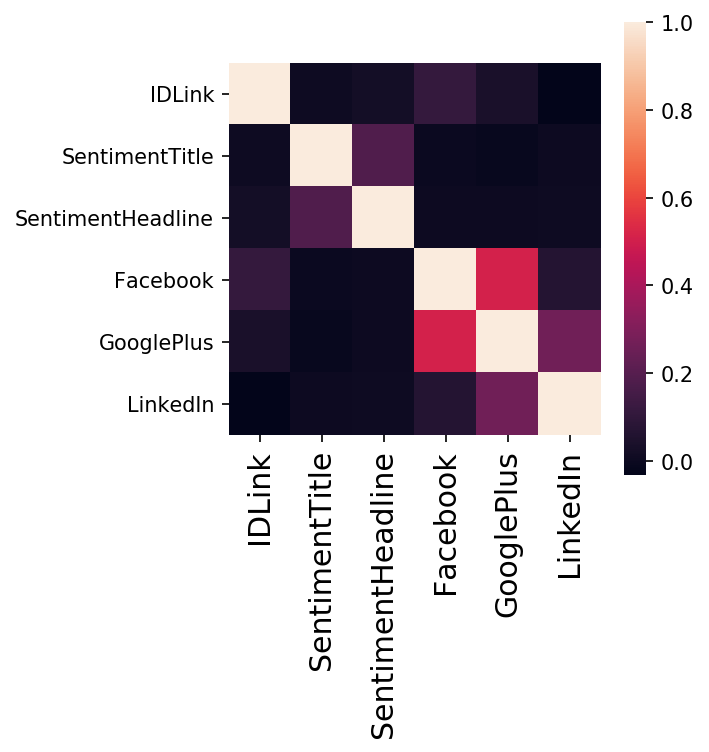

In [12]:
# Correlation matrix visualization 

f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corr_matrix, vmax=1, square=True);

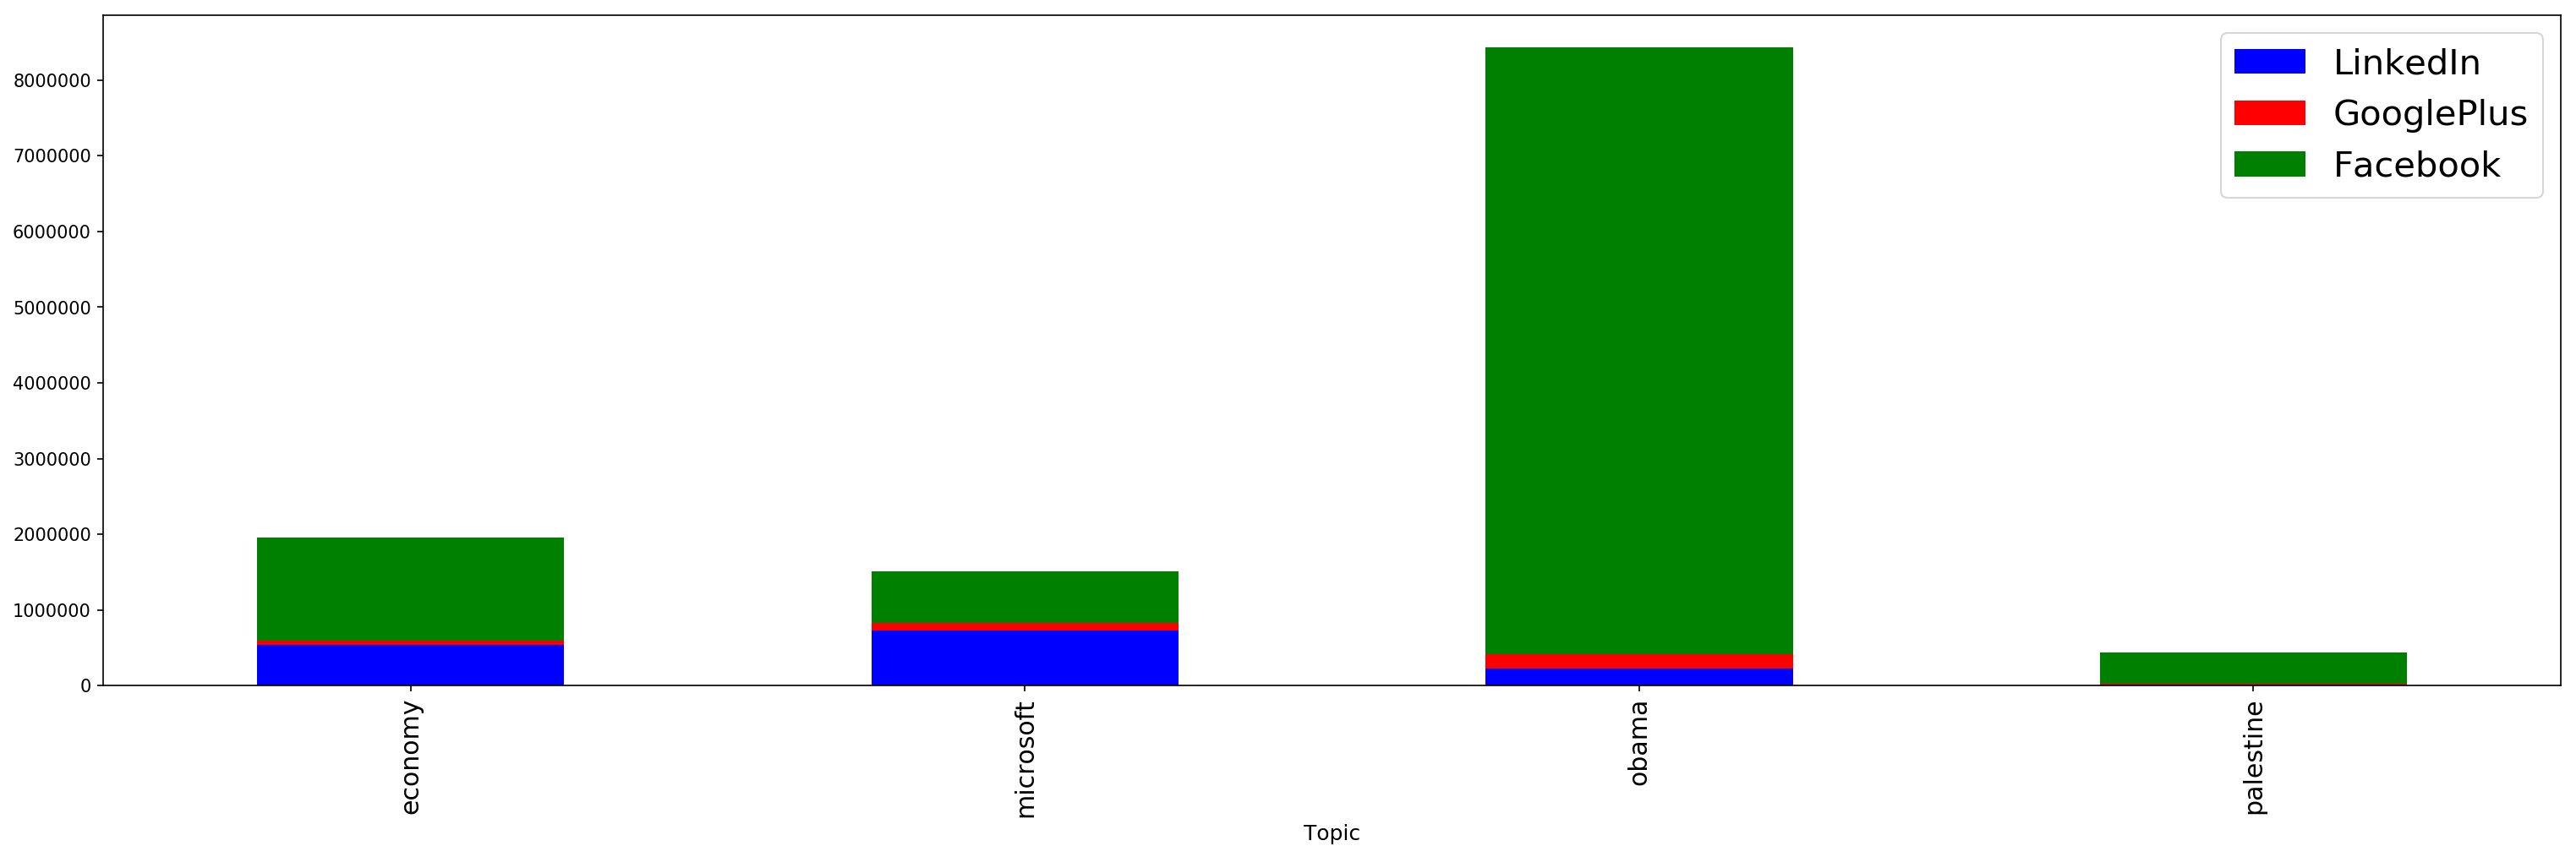

In [13]:
#Bar graph exploring which Topics have the most popularity on the three different social media platforms. 

data.groupby('Topic').agg('sum')[['LinkedIn','GooglePlus', 'Facebook']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r', 'g']);

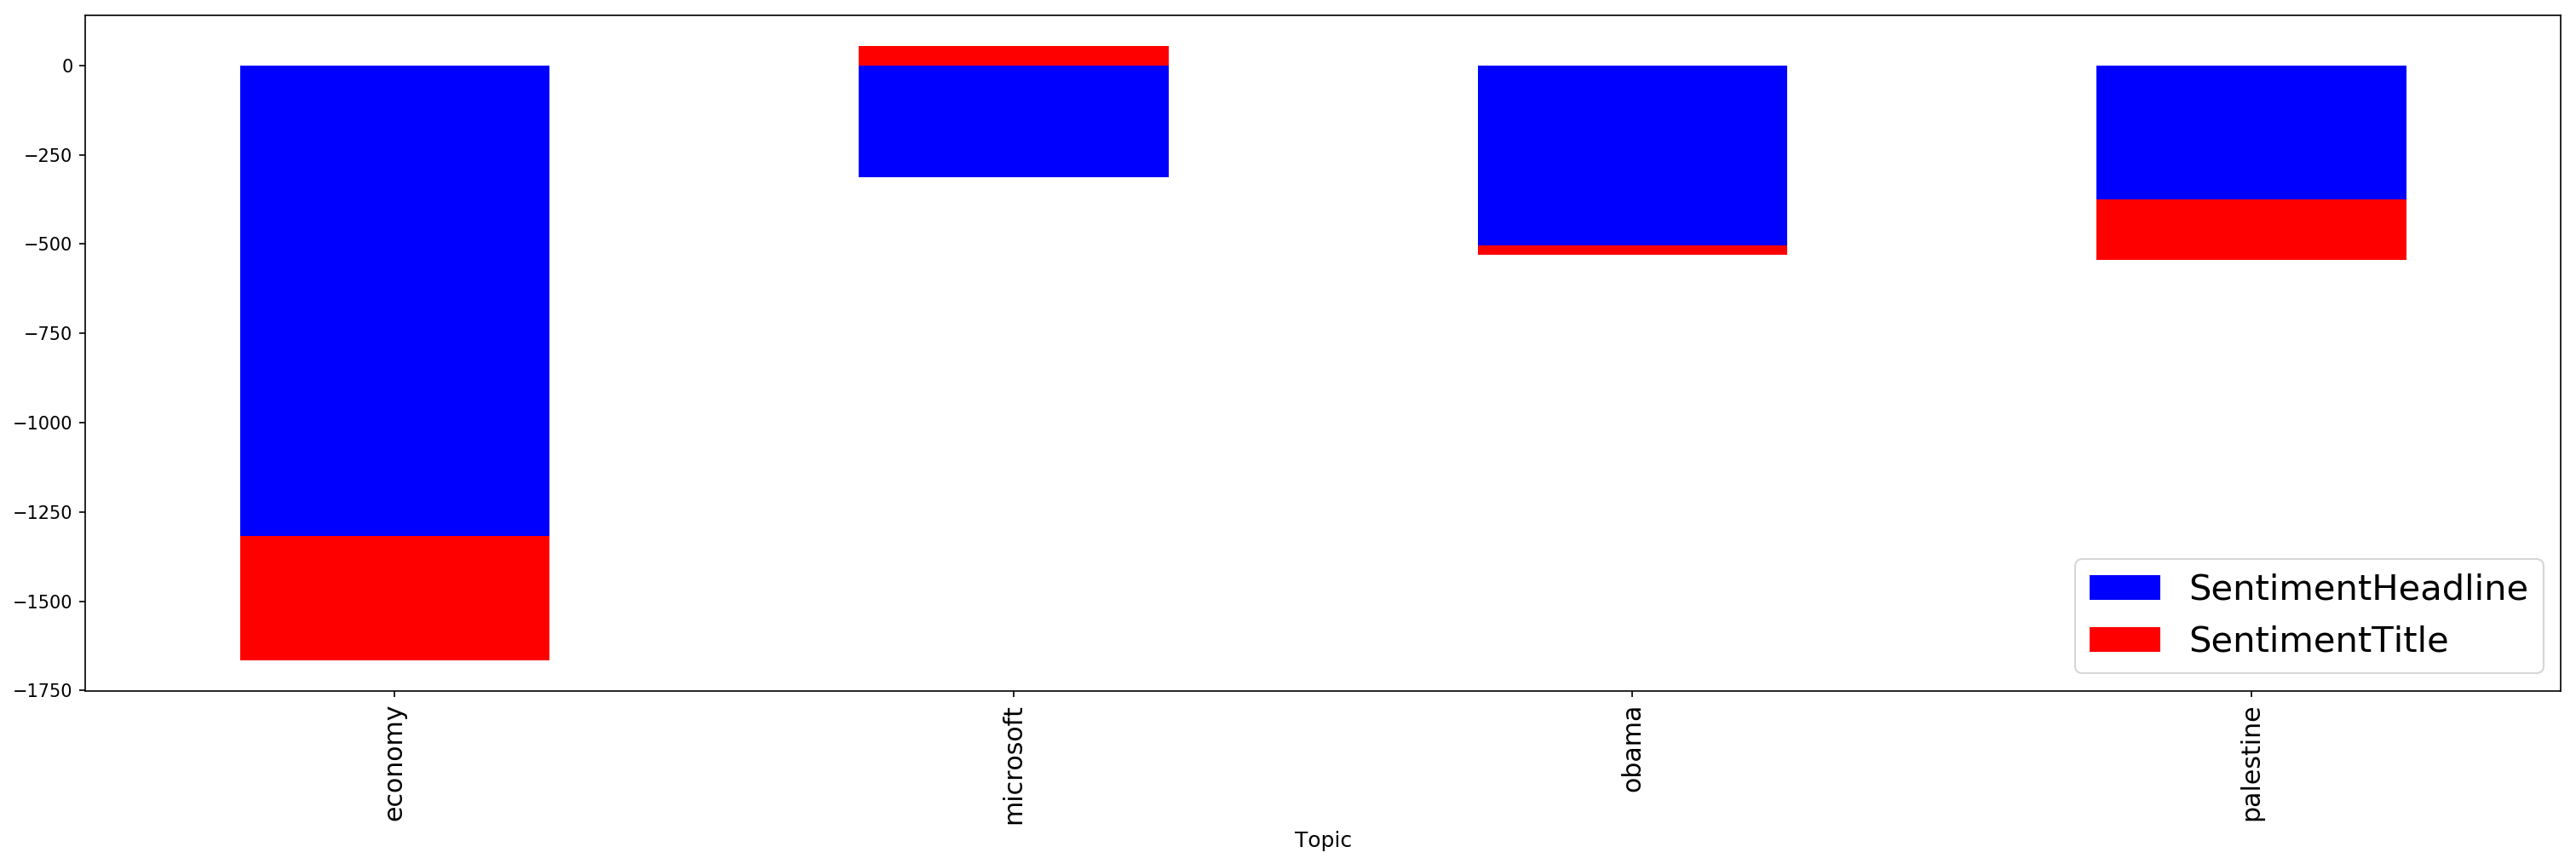

In [14]:
# Bar graph exploring total sentiment for the different topics

data.groupby('Topic').agg('sum')[['SentimentHeadline', 'SentimentTitle']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r', 'g']);

## GooglePlus and Facebook

##### If given the Facebook popularity for a news story, can we accuractely predict its popularity on GooglePlus?

In [15]:
# Downsample 10000 entries for training

data = data.sample(n=10000, random_state=42)

In [16]:
# Create a new dataset with only the features we want

data_social = data[['GooglePlus','Facebook']]  
data_social.head()

,GooglePlus,Facebook
30975,0,0
20286,0,0
64492,0,20
53248,0,27
63769,0,4


In [17]:
# Splitting up our input (Facebook) from our target (GooglePlus)

X = data_social.drop('GooglePlus', axis = 1)
y = data_social['GooglePlus'].copy()

In [18]:
# Splitting up our training data from our test data

social_X_train, social_X_test, social_y_train, social_y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(social_X_train.shape)
print(social_X_test.shape)
print(social_y_train.shape)
print(social_y_test.shape)

(8000, 1)
(2000, 1)
(8000,)
(2000,)


## Linear Regression

In [19]:
# Linear Regression - A regression model that outputs a continuous value from a linear combination of input features

regr = linear_model.LinearRegression()

In [20]:
# We will time how long it takes to fit the model

start_time = time()
regr.fit(social_X_train, social_y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.01s


In [21]:
# Coefficient - the value that multiplies the predictor value.

print('Coefficients: \n', regr.coef_)

Coefficients: 
 [0.02135163]


In [22]:
# Time to predict

social_y_pred = regr.predict(social_X_test)

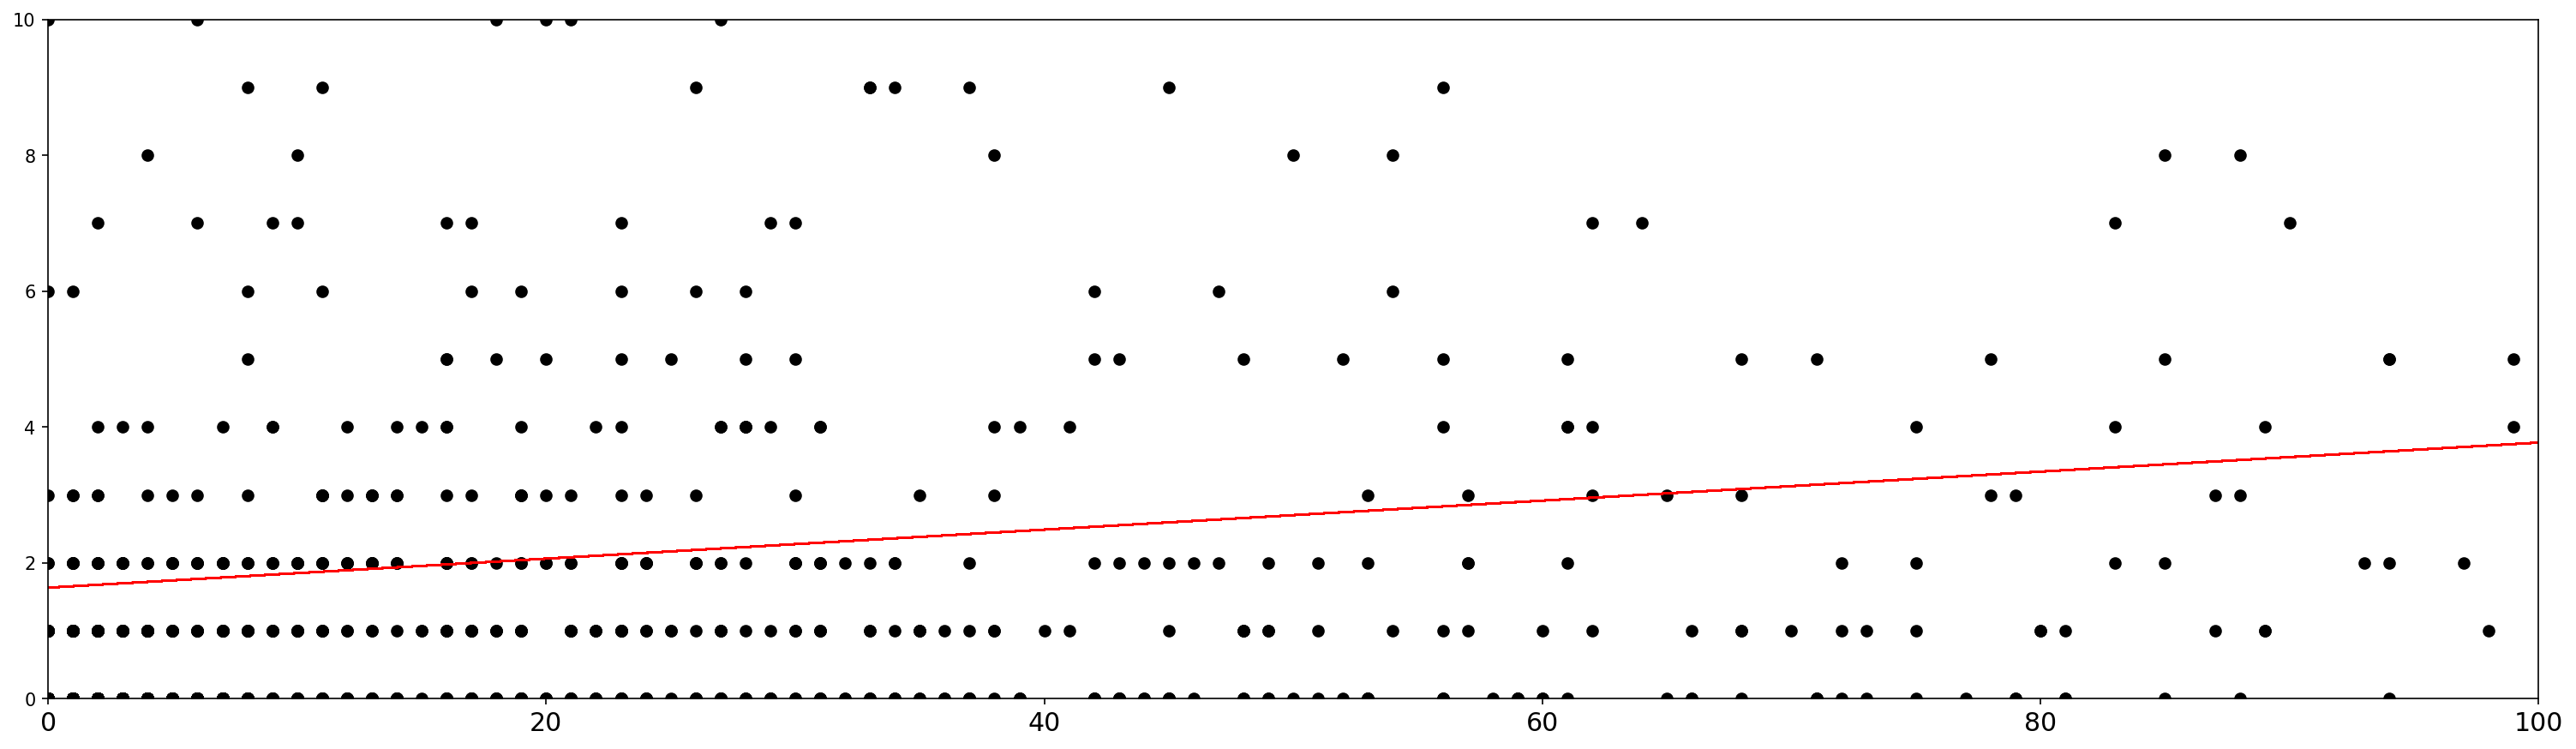

In [23]:
# Lets see what our prediction looks like

plt.scatter(social_X_test, social_y_test,  color='black')
plt.plot(social_X_test, social_y_pred, color='red', linewidth=1)
plt.axis([0, 100, 0, 10])
plt.show()

In [24]:
# Mean Squared Error - the average square loss per example.(the larger the number, the larger the error)

print("Mean squared error: %.2f"
      % mean_squared_error(social_y_test, social_y_pred))

Mean squared error: 269.41


In [25]:
# Variance Score - how far observed values differ from the avg. of predicted values (1.0 being the max)

print('Variance score: %.2f' % r2_score(social_y_test, social_y_pred))

Variance score: 0.29


## Ridge Regression

In [26]:
# Ridge Regression - a regularized form of Linear Regression.
# random_state reproduces the same sequence of random numbers for comparing identical training sessions.

ridge_regr = Ridge(alpha=1, random_state=42, solver='saga')

In [27]:
# We time how long it takes to fit the model

start_time = time()
ridge_regr.fit(social_X_train, social_y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.02s


In [28]:
# Time to predict

social_y_pred = ridge_regr.predict(social_X_test)

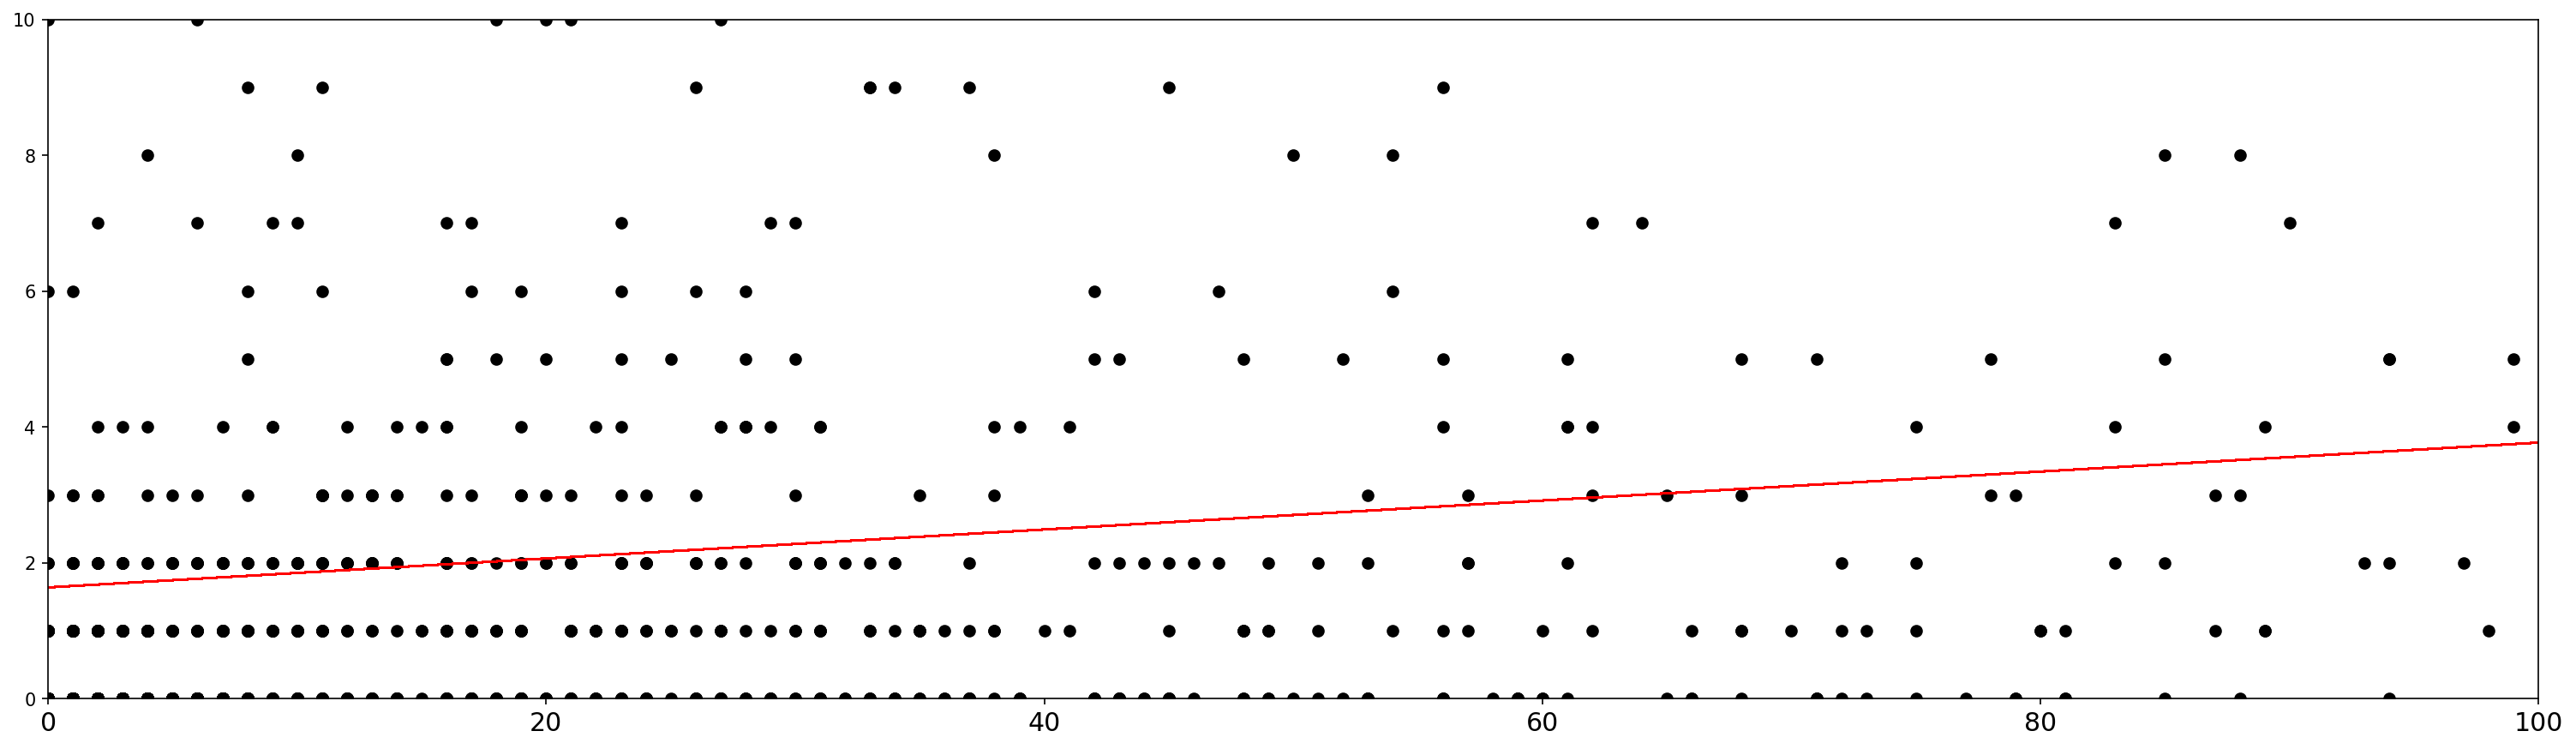

In [29]:
# Lets see what our prediction looks like

plt.scatter(social_X_test, social_y_test,  color='black')
plt.plot(social_X_test, social_y_pred, color='red', linewidth=1)
plt.axis([0, 100, 0, 10])
plt.show()

In [30]:
# Mean Squared Error - the average square loss per example.(the larger the number, the larger the error)

print("Mean squared error: %.2f"
      % mean_squared_error(social_y_test, social_y_pred))

Mean squared error: 269.31


In [31]:
# Variance Score - how far observed values differ from the avg. of predicted values (1.0 being the max)

print('Variance score: %.2f' % r2_score(social_y_test, social_y_pred))

Variance score: 0.29


## Lasso Regression

In [32]:
# Lasso Regression - Least Absolute Shrinkage and Selection Operator Regression is another regularized form of Linear Regression.
# random_state reproduces the same sequence of random numbers for comparing identical training sessions.

lasso_regr = linear_model.Lasso(alpha=1, random_state=42, max_iter=10)

In [33]:
# We time how long it takes to fit the model

start_time = time()
lasso_regr.fit(social_X_train, social_y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.00s


In [34]:
# Time to predict

social_y_pred = lasso_regr.predict(social_X_test)

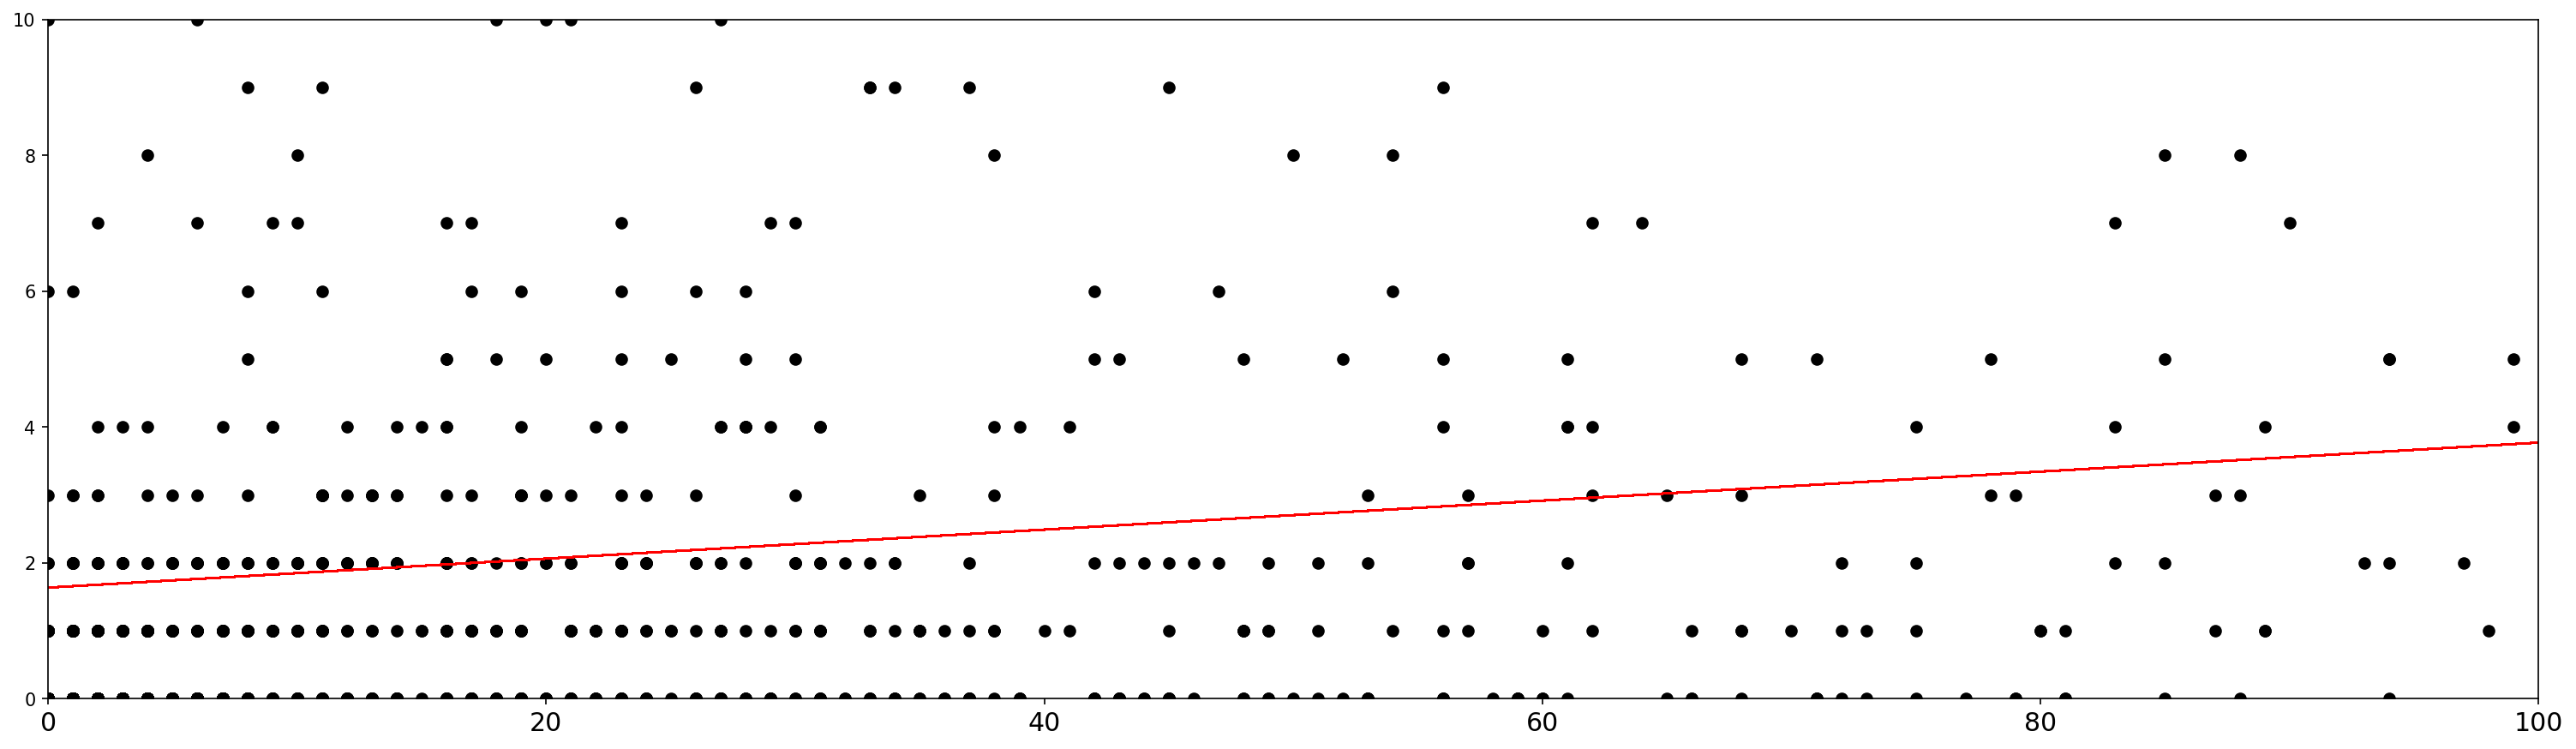

In [35]:
# Lets see what our prediction looks like

plt.scatter(social_X_test, social_y_test,  color='black')
plt.plot(social_X_test, social_y_pred, color='red', linewidth=1)
plt.axis([0, 100, 0, 10])
plt.show()

In [36]:
# Mean Squared Error - the average square loss per example.(the larger the number, the larger the error)

print("Mean squared error: %.2f"
      % mean_squared_error(social_y_test, social_y_pred))

Mean squared error: 269.39


In [37]:
# Variance Score - how far observed values differ from the avg. of predicted values (1.0 being the max)

print('Variance score: %.2f' % r2_score(social_y_test, social_y_pred))

Variance score: 0.29


## SentimentHeadline

#### If given Facebook popularity for news stories, what is the predicted Sentimentheadline score?

In [38]:
# Create a new dataset with only the features we want

data_social2 = data[['SentimentHeadline','Facebook']]  
data_social2.head()

,SentimentHeadline,Facebook
30975,0.050162,0
20286,0.007218,0
64492,-0.058645,20
53248,0.000000,27
63769,-0.060211,4


In [39]:
# Splitting up our input (Facebook) from our target (SentimentHeadline)

X = data_social2.drop('SentimentHeadline', axis = 1)
y = data_social2['SentimentHeadline'].copy()

In [40]:
# Splitting up our training data from our test data

social_X_train2, social_X_test2, social_y_train2, social_y_test2 = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(social_X_train2.shape)
print(social_X_test2.shape)
print(social_y_train2.shape)
print(social_y_test2.shape)

(8000, 1)
(2000, 1)
(8000,)
(2000,)


In [41]:
# Linear Regression - A regression model that outputs a continuous value from a linear combination of input features

regr2 = linear_model.LinearRegression()

In [42]:
# We will time how long it takes to fit the model

start_time = time()
regr.fit(social_X_train2, social_y_train2)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.00s


In [43]:
# Coefficient - the value that multiplies the predictor value.

print('Coefficients: \n', regr.coef_)

Coefficients: 
 [8.6798371e-07]


In [44]:
# Time to predict

social_y_pred2 = regr.predict(social_X_test2)

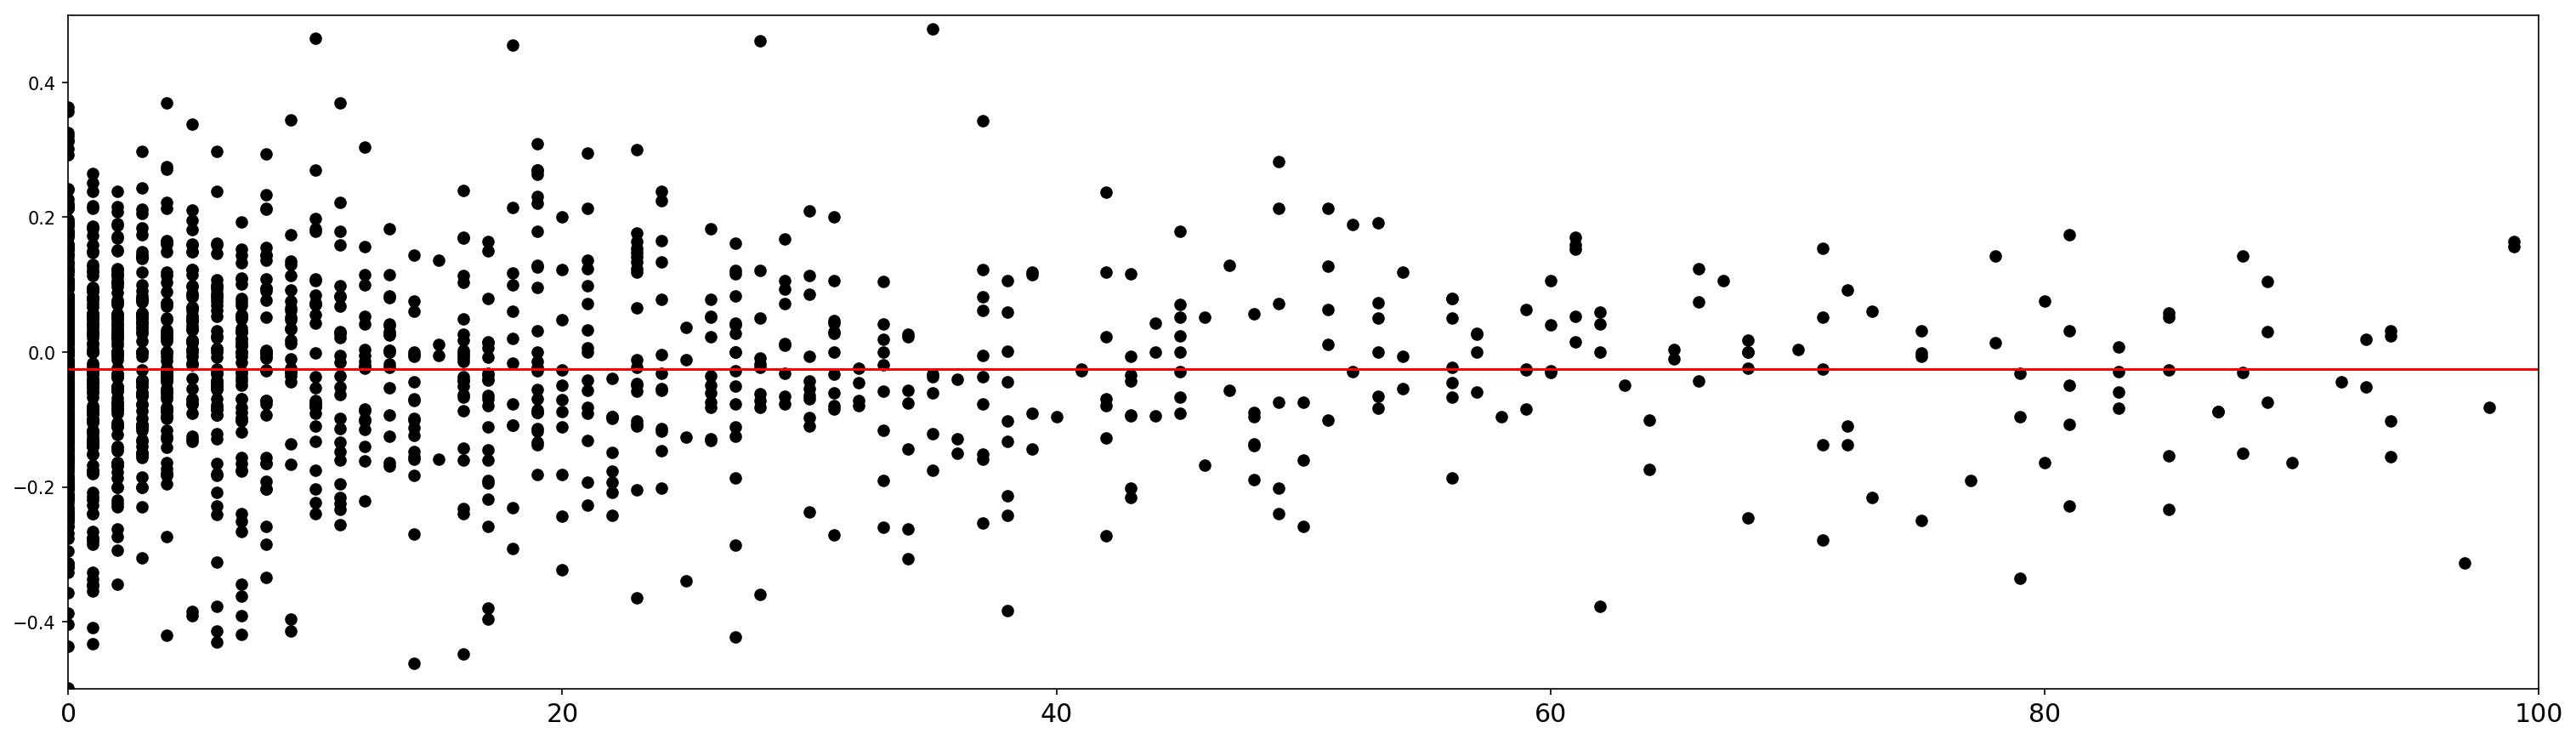

In [45]:
# Lets see what our prediction looks like

plt.scatter(social_X_test2, social_y_test2,  color='black')
plt.plot(social_X_test2, social_y_pred2, color='red', linewidth=1)
plt.axis([0, 100, -0.5, 0.5])
plt.show()

In [46]:
# Mean Squared Error - the average square loss per example.(the larger the number, the larger the error)

print("Mean squared error: %.2f"
      % mean_squared_error(social_y_test2, social_y_pred2))

Mean squared error: 0.02


In [47]:
# Variance Score - how far observed values differ from the avg. of predicted values (1.0 being the max)

print('Variance score: %.2f' % r2_score(social_y_test2, social_y_pred2))

Variance score: -0.00


## What time of day results in the most popular news stories?

In [48]:
# First we need to do some feature engineering and break apart PublishDate and create a seperate Time field

data['Time'] = pd.to_datetime(data['PublishDate'],format= '%m/%d/%y %H:%M' ).dt.time

In [49]:
# Then we convert our Time field into a minutes field as a float is required for training

data['Minutes'] = data.Time.apply(lambda x:((x.hour*60+x.minute)*60+x.second)/60)

In [50]:
# Create a new dataset with only the features we want

data_time = data[['Minutes','Facebook']]  
data_time.head()

,Minutes,Facebook
30975,1358.0,0
20286,159.0,0
64492,889.0,20
53248,1028.0,27
63769,1202.0,4


In [51]:
# Splitting up our input 'X' (Minutes) from our target 'y' (Facebook, GooglePlus, LinkedIn)

X = data_time.drop('Facebook', axis=1)
y = data_time.drop('Minutes', axis =1)


In [52]:
# Splitting up our training data from our test data

time_X_train, time_X_test, time_y_train, time_y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(time_X_train.shape)
print(time_X_test.shape)
print(time_y_train.shape)
print(time_y_test.shape)

(8000, 1)
(2000, 1)
(8000, 1)
(2000, 1)


In [53]:
# Linear Regression - A regression model that outputs a continuous value from a linear combination of input features

regr_time = linear_model.LinearRegression()

In [54]:
# We will time how long it takes to fit the model

start_time = time()
regr.fit(time_X_train, time_y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.00s


In [55]:
# Coefficient - the value that multiplies the predictor value.

print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[0.02927553]]


In [56]:
# Time to predict

time_y_pred = regr.predict(time_X_test)

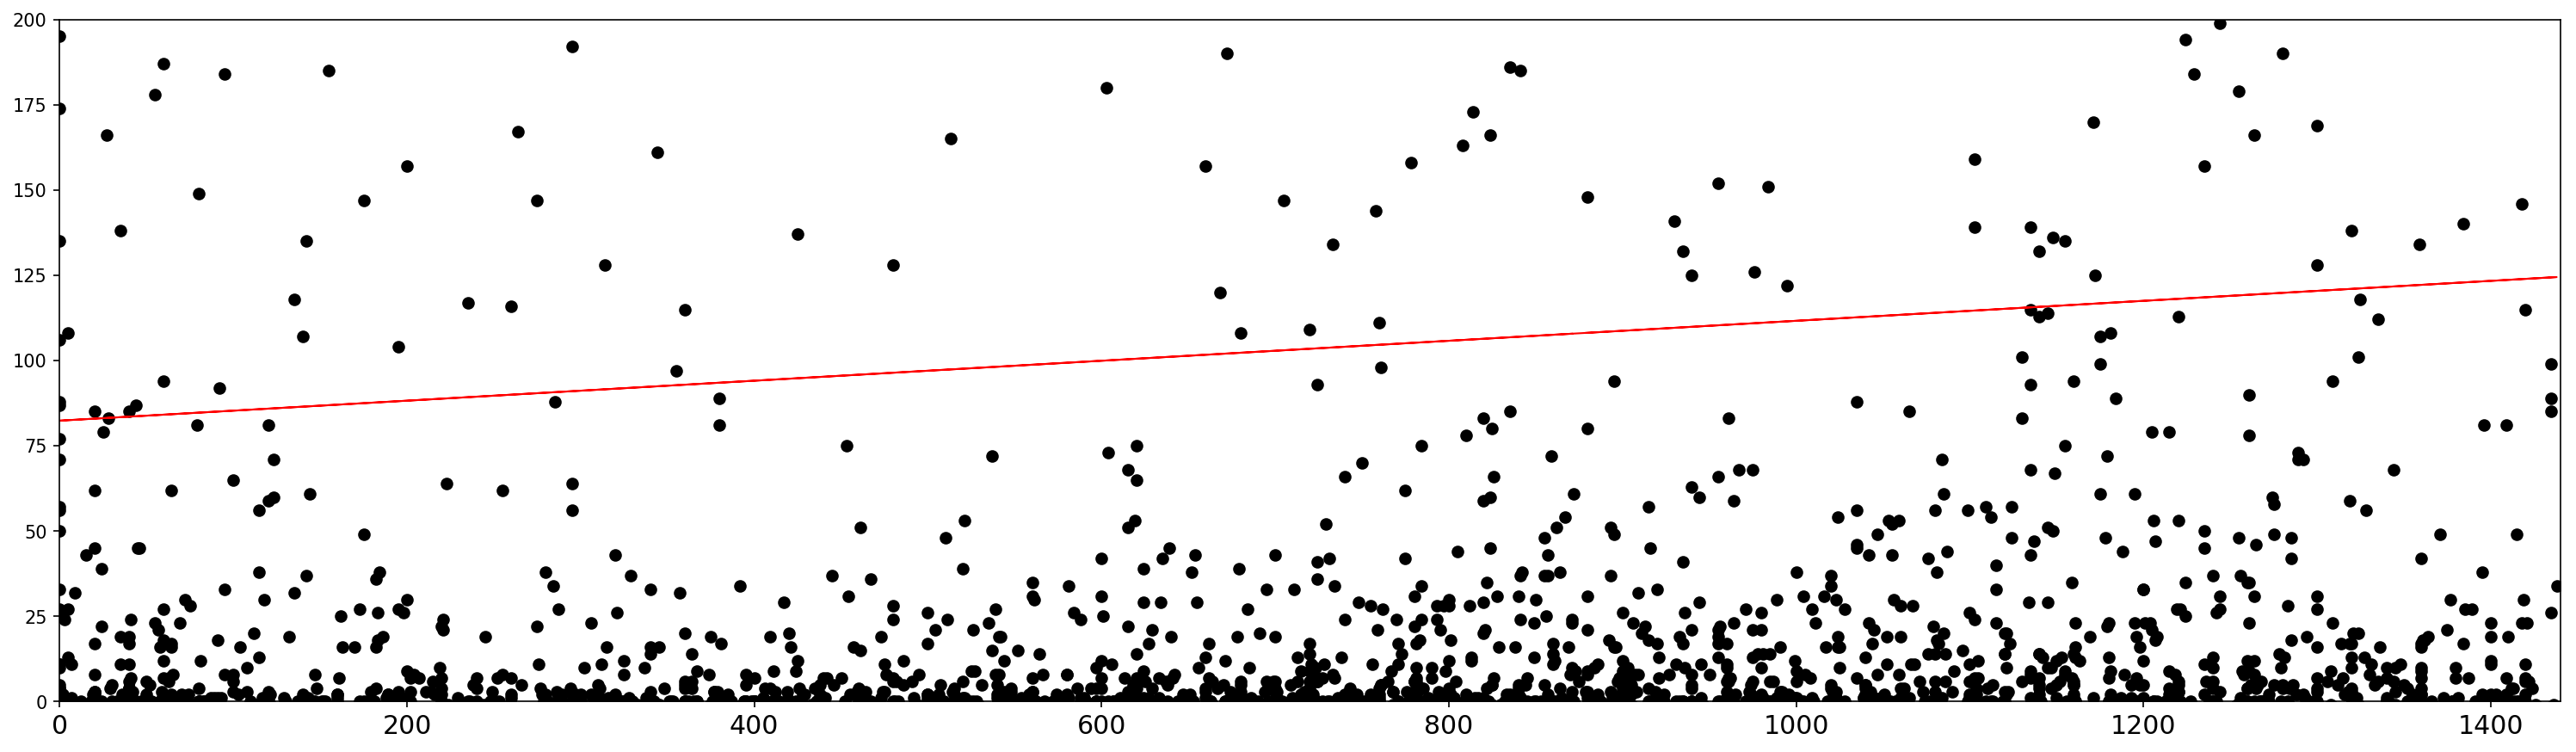

In [57]:
# Lets see what our prediction looks like

plt.scatter(time_X_test, time_y_test,  color='black')
plt.plot(time_X_test, time_y_pred, color='red', linewidth=1)
plt.axis([0, 1440, 0, 200])
plt.show()

In [58]:
# Mean Squared Error - the average square loss per example.(the larger the number, the larger the error)

print("Mean squared error: %.2f"
      % mean_squared_error(time_y_test, time_y_pred))

Mean squared error: 387225.63


In [59]:
# Variance Score - how far observed values differ from the avg. of predicted values (1.0 being the max)

print('Variance score: %.2f' % r2_score(time_y_test, time_y_pred))

Variance score: 0.00
